Student Data Sample:
+---------+------+---+----------+------+----------+-----------+
|StudentID|Gender|Age|Attendance|Grades|StudyHours|Performance|
+---------+------+---+----------+------+----------+-----------+
|        1|Female| 21|        70| 72.87|      6.61|     Medium|
|        2|  Male| 19|        99| 46.43|      3.09|        Low|
|        3|Female| 22|       100| 46.67|      3.19|        Low|
|        4|  Male| 24|        53| 76.11|      5.11|     Medium|
|        5|  Male| 23|        78| 63.68|      2.56|     Medium|
+---------+------+---+----------+------+----------+-----------+
only showing top 5 rows

Aggregated Insights:
+----------------+-----------------+------------------+
|PerformanceLabel|    AvgStudyHours|         AvgGrades|
+----------------+-----------------+------------------+
|            High|5.271762452107284| 92.74095785440613|
|             Low|5.331785714285714|44.407440476190466|
|          Medium|5.370140105078811|  67.7191418563923|
+----------------+---

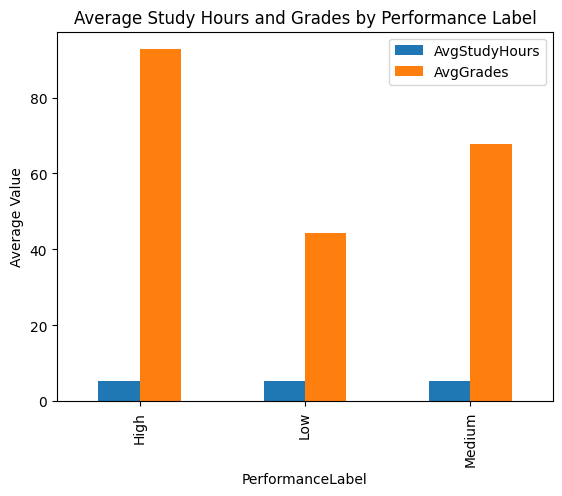

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, when
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Big Data in Education") \
    .getOrCreate()

# Step 2: Load Student Data from HDFS or Local File
file_path = "student_data.csv"  # Replace with actual local path or HDFS path
student_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the first few rows
print("Student Data Sample:")
student_df.show(5)

# Step 3: Data Preprocessing
# Select relevant columns for analysis
columns_to_analyze = ["StudentID", "Gender", "Age", "Attendance", "Grades", "StudyHours", "Performance"]
student_df = student_df.select(columns_to_analyze)

# Handle missing values
student_df = student_df.na.fill({"Attendance": 0, "Grades": 0, "StudyHours": 0, "Performance": "Low"})

# Add a performance label (e.g., Low, Medium, High) based on grades
student_df = student_df.withColumn(
    "PerformanceLabel",
    when(col("Grades") >= 85, "High")
    .when(col("Grades") >= 50, "Medium")
    .otherwise("Low")
)

# Step 4: Aggregate Insights
# Calculate average study hours and grades by performance label
aggregated_data = student_df.groupBy("PerformanceLabel").agg(
    avg("StudyHours").alias("AvgStudyHours"),
    avg("Grades").alias("AvgGrades")
)

print("Aggregated Insights:")
aggregated_data.show()

# Step 5: Export Preprocessed Data to Pandas for ML
student_pandas_df = student_df.toPandas()

# Convert PerformanceLabel to numerical values for ML
student_pandas_df["PerformanceLabelNum"] = student_pandas_df["PerformanceLabel"].map({"Low": 0, "Medium": 1, "High": 2})

# Features and target
X = student_pandas_df[["Attendance", "Grades", "StudyHours"]]
y = student_pandas_df["PerformanceLabelNum"]

# Step 6: Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train a Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 8: Evaluate the Model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 9: Visualize Insights
# Plot average study hours and grades
avg_data = aggregated_data.toPandas()
avg_data.plot(x="PerformanceLabel", y=["AvgStudyHours", "AvgGrades"], kind="bar")
plt.title("Average Study Hours and Grades by Performance Label")
plt.ylabel("Average Value")
plt.show()

# Step 10: Save Results
# Save the DataFrame locally instead of HDFS
output_path = "processed_student_data"  # Change to a local path or HDFS path if needed
student_df.write.csv(output_path, header=True)

# Step 11: Stop Spark Session
spark.stop()

